In [1]:
import pandas as pd
import numpy as np
from utils.evaluation import Evaluation
from utils.tripadvisor_site_driver import TripadvisorSiteDriver
import re
import copy
import textwrap
import matplotlib.pyplot as plt

# It automatically reloads your modules whenever
%load_ext autoreload
%autoreload 2


### Helper Functions

In [2]:
def plot_eval_results(eval_results:dict):
    """
    Plotting Evaluation Results of the Models
    """
    eval_results_ = copy.deepcopy(eval_results)
    row_labels = [d['Model Name'] for d in eval_results_]
    for d in eval_results_:
        d.pop('Model Name', None)

    # Determine Columns and the Rows  colors
    col_colors = np.full(len(list(eval_results_[0].keys())), '#7AC5CD')
    row_colors = np.full(len(eval_results_), '#FFD39B')

    # Axis Specification 
    plt.axis('off')
    plt.axis('tight')
    
    # Create the table
    table = plt.table(cellText=[list(d.values()) for d in eval_results_], colLabels=list(eval_results_[0].keys()),
                      rowLabels=row_labels,
                      rowColours=row_colors,
                      colColours=col_colors,
                      colWidths=[0.22, 0.02, 0.08,0.08,0.08], 
                      loc='best')

    # Customize the table appearance
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(6, 8) 
    table.auto_set_column_width([0, 1])

    plt.plot()
    plt.show()

## Evaluation with Manual Generated Evaluation Set

### Path Config

Please Specify Result Path & Evaluation Set Path 

In [3]:
model_results_path = 'data/query_results.csv'
evaluation_set_path = 'data/evaluation_set.csv'

### Read Results and Evaluation Set Path

In [4]:
model_results_df = pd.read_csv(model_results_path)
evaluation_set_df = pd.read_csv(evaluation_set_path)


#### Evaluation Set

In [5]:
evaluation_set_df.head()

,Name,Cuisine Type,Expensiveness,Country,Mean Rating,Terrace Available,Vegetarian Menu Available,Wine Menu Available
0,Aila,"Modern Cuisine, Turkish",2,Turkey,42.400000,True,True,False
1,Turk Fatih Tutak,"Modern Cuisine, Turkish",5,Turkey,46.764706,False,True,True
2,SADE Beş Denizler Mutfağı,Traditional Cuisine,2,Turkey,46.000000,True,True,False
3,Tatbak,"Turkish, Traditional Cuisine",2,Turkey,44.216867,False,False,False
4,Şans,"Turkish, Mediterranean Cuisine",3,Turkey,46.800000,True,True,True


#### Model Results

In [6]:
model_results_df.head()

,Model Name,Query Number,Query,Model Result,Ranking
0,supp_model_1,1,I am planning a holiday trip to Turkey and I a...,Lokanta 1741,1
1,supp_model_1,1,I am planning a holiday trip to Turkey and I a...,Quartopiano Suite Restaurant,2
2,supp_model_1,1,I am planning a holiday trip to Turkey and I a...,Atölye,3
3,supp_model_1,1,I am planning a holiday trip to Turkey and I a...,Bedem,4
4,supp_model_1,1,I am planning a holiday trip to Turkey and I a...,Mater Terrae,5


#### We manually classify the restaurants based on serving Wine and Terrace view and serving Vegetarian Menu
#### Therefore, the query should includes only these parameters and/or country to evalute the models
Plase Note: Query Format should be ..... {Wine/Terrace/Vegetarian} .... {Country}\
Example Query: best restaurants with terrace in Italy 	

### Compute Evaluation Metrics

In [7]:
def determine_evaluation_set_column_name_for_classification(query: str):
    """
    Determine the Column Name in the Evaluation Set
    """
    if 'terrace' in query or 'Terrace' in query:
        column_name = 'Terrace Available'
        
    elif 'vegetarian' in query or 'vegeterian' in query:
        column_name = 'Vegetarian Menu Available'
        
    else:
        column_name = 'Wine Menu Available'

    return column_name 

    
def calculate_eval_metrics(results_df, queries, model_names, country_name):
    """
    Calculate Evaluation Results
    """
    eval_results = []
    for query in queries:
        for name in model_names:
            query_groups = results_df[(results_df['Query'] == query) & 
                                     (results_df['Model Name'] == name)].groupby('Query Number')

            column_name = determine_evaluation_set_column_name_for_classification(query)
            all_eval_data_for_given_query = evaluation_set_df[(evaluation_set_df['Country'] == country_name) & 
                                                              (evaluation_set_df[column_name] == True)]
            sorted_eval_data = all_eval_data_for_given_query.sort_values('Mean Rating', ascending=False)

            for group in query_groups:
                evaluator = Evaluation()
                precision_at_k, recall_at_k = evaluator.calculate_pr_at_k(group[1]['Model Result'].values, 
                                                                          sorted_eval_data['Name'].values,10)

                rating_data = dict(zip(sorted_eval_data['Name'], sorted_eval_data['Mean Rating']/10))
                ncdg = evaluator.compute_ndcg_with_ratings(group[1]['Model Result'].values, 
                                                           sorted_eval_data['Name'].values,
                                                           rating_data)
                
                average_precision = evaluator.calculate_average_precision(group[1]['Model Result'].values, 
                                                      sorted_eval_data['Name'].values)
                wrapper = textwrap.TextWrapper(width=30)

                word_list = wrapper.wrap(text=query)
                word_list = '\n'.join(word_list)
                eval_results.append({'Query': word_list,'Query \n No': group[0],
                                     'Model Name': name, 'Precision@10': round(precision_at_k,3),
                                     'NCDG@10':round(ncdg,3),
                                     'Avg.\n Precision \n @10': round(average_precision,3)})
    return eval_results
            

## Plot Results Table

### Results without any Relevance Feedback - Query consists 'Turkey'

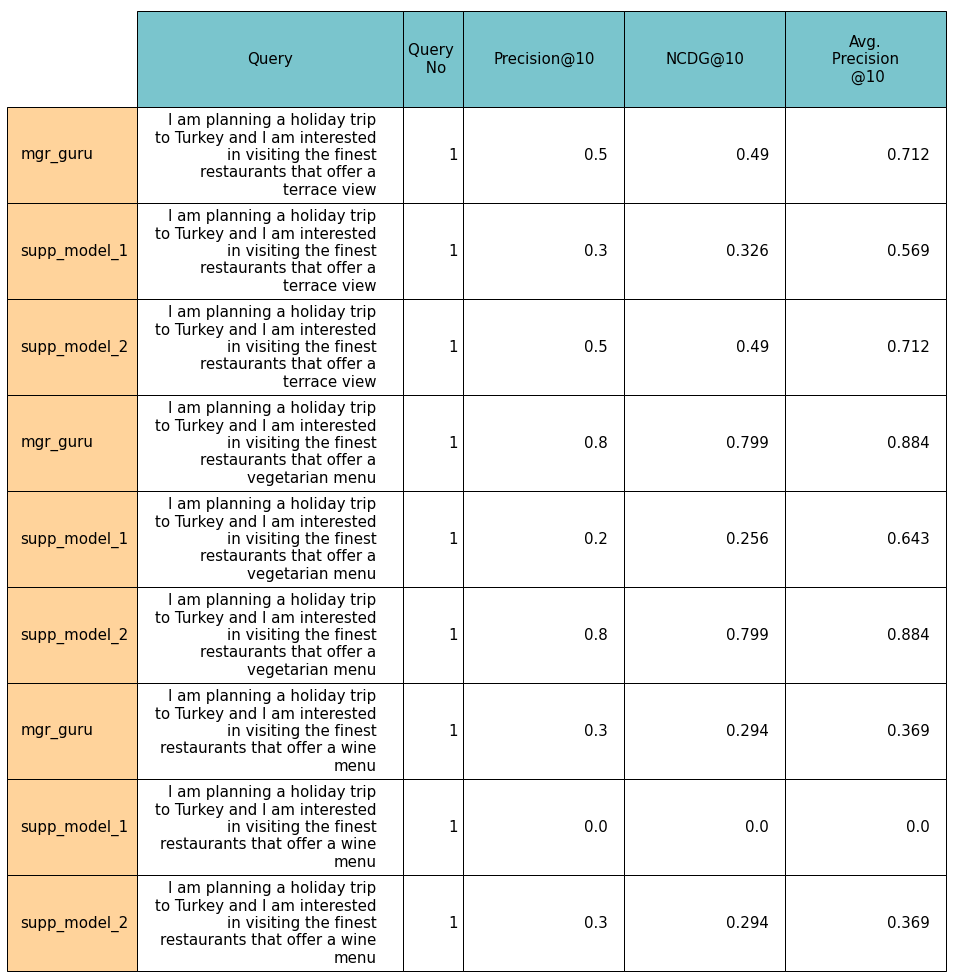

In [8]:
queries = np.unique(model_results_df['Query'])
queries = np.array([query for query in queries if 'Turkey' in query])
model_names = np.unique(model_results_df['Model Name'])
results_df = model_results_df[model_results_df['Query Number'] == 1]
eval_results = calculate_eval_metrics(results_df, queries, model_names, 'Turkey')
plot_eval_results(eval_results)

### Results Before&After Relevance Feedback to Same Query - Query consists 'Turkey'

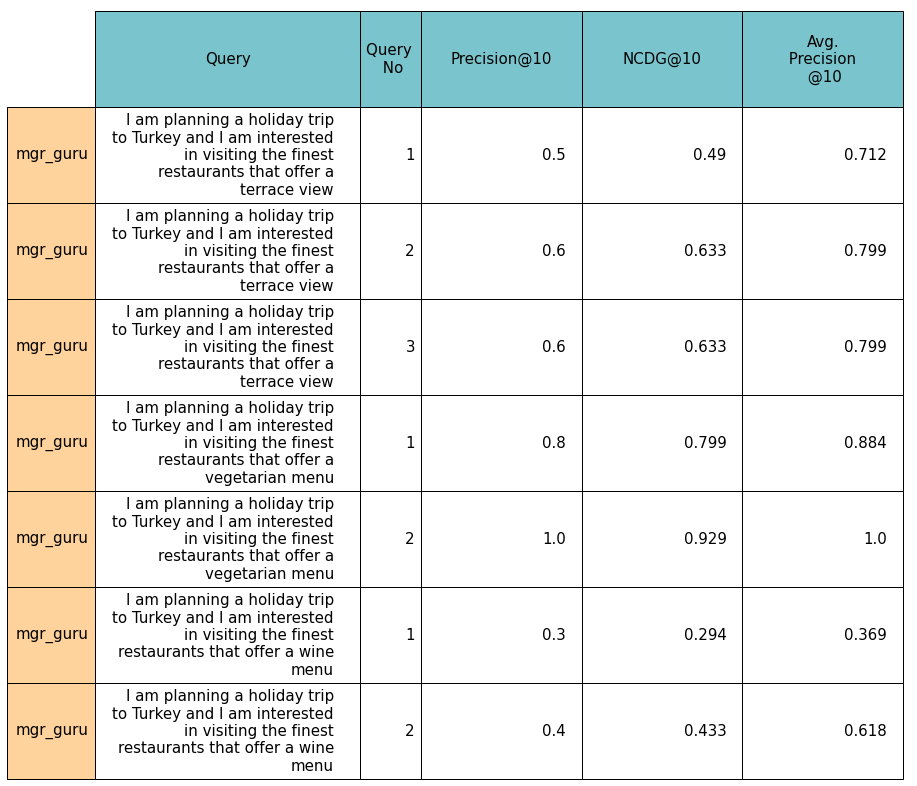

In [9]:
queries = np.unique(model_results_df['Query'])
queries = np.array([query for query in queries if 'Turkey' in query])
model_names = np.array(['mgr_guru'])
eval_results = calculate_eval_metrics(model_results_df, queries, model_names, 'Turkey')
plot_eval_results(eval_results)

### Results After Relevance Feedback to Similar Query - Query consists 'Italy'

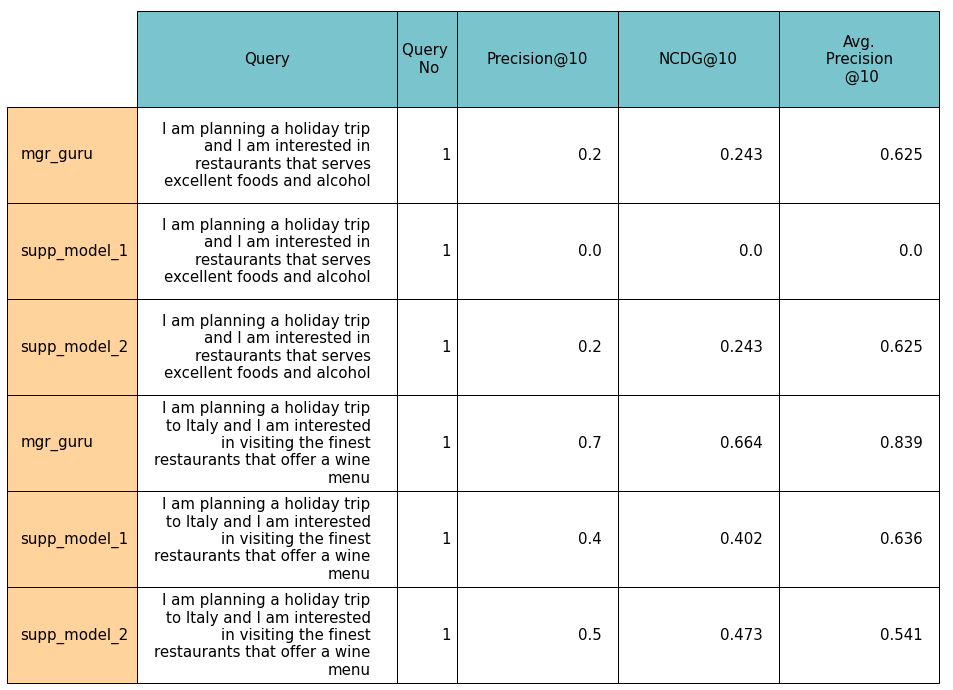

In [11]:
queries = np.unique(model_results_df['Query'])
queries = np.array([query for query in queries if 'Turkey' not in query])
model_names = np.unique(model_results_df['Model Name'])
eval_results = calculate_eval_metrics(model_results_df, queries, model_names, 'Italy')
plot_eval_results(eval_results)


## Evalaute MGR-Guru Directly via the TripAdvisor Site


Check the MGR-Guru model results with directly TripAdvisor Site.\
We searched the query with MGR-Guru and then search the corresponding query in Trip Advisor Site to generate 
evaluation dataset.

For instance,\
**MGR-Guru Model Query:** 'I am planning a holiday trip to Turkey and I am in visiting the finest restaurants that offer a terrace view'\
**Trip Advisor Query:** 'restaurants with terrace view in Turkey'

Then, the code below calculates the NCDG@10 and Precision@10 Before and After the Relevance Feedback based on a Trip Advisor website.




In [12]:
def update_characters_in_name(query_rating_tuple_list_, string_list):
    """
    Update Turkish Characters
    """
    updated_list = []

    for tuple_ in query_rating_tuple_list_:
        for search_string in string_list:
            string_wout_turkish_chars = search_string.translate(str.maketrans("ŞÇÖĞÜşçöğüıİ", "SCOGUscoguiI"))
            if string_wout_turkish_chars in tuple_[0]:
                updated_tuple = (search_string, tuple_[1])
                updated_list.append(updated_tuple)
                break
        else:
            updated_list.append(tuple_)

    return updated_list

In [13]:
curQuery = 'I am planning a holiday trip to Turkey and I am interested in visiting the finest restaurants that offer a terrace view'
tripAdvisorQuery = 'restaurants with terrace view in Turkey'


site_driver = TripadvisorSiteDriver()
for i in [1,2]:
    evaluator = Evaluation()
    site_driver.open_driver()
    tripadvisor_query_results = site_driver.get_query_results(tripAdvisorQuery, 10)
    site_driver.close_driver()

    model_results = model_results_df.query(f"`Model Name` == 'mgr_guru' and\
                                           Query == '{curQuery}' and `Query Number` == {i}")


    model_document_names = model_results["Model Result"].values.tolist()
    tripadvisor_query_results_ = update_characters_in_name(tripadvisor_query_results, model_document_names)


    # Calculate Precision@k
    tripadvisor_documents_names = [x[0] for x in tripadvisor_query_results_]
    precision_at_k, recall_at_k = evaluator.calculate_pr_at_k(model_document_names, tripadvisor_documents_names, 10)


    # Sort by Tripadvisor rating and calculate NCDG
    sorted_data = sorted(tripadvisor_query_results_, key=lambda x: x[1])
    rating_data = {item[0]: item[1] for item in sorted_data} 
    ncdg = evaluator.compute_ndcg_with_ratings(model_document_names, tripadvisor_documents_names,
                                                rating_data)

    print(f"Query:{curQuery} \n Query No:{i}, Model Name: mgr_guru, Precision@10:{precision_at_k}, NCDG@10: {ncdg}")


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [/home/ibrahim/.wdm/drivers/chromedriver/linux64/112.0.5615.49/chromedriver] found in cache


Query:I am planning a holiday trip to Turkey and I am interested in visiting the finest restaurants that offer a terrace view 
 Query No:1, Model Name: mgr_guru, Precision@10:0.5, NCDG@10: 0.5110283684834236



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [/home/ibrahim/.wdm/drivers/chromedriver/linux64/112.0.5615.49/chromedriver] found in cache


Query:I am planning a holiday trip to Turkey and I am interested in visiting the finest restaurants that offer a terrace view 
 Query No:2, Model Name: mgr_guru, Precision@10:0.5, NCDG@10: 0.6155543860581939


Results based on Trip Advisor Site Dataset show that relevance feedback increase the utility of the results(NCDG) but the precision is not changed.